## **Load data**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%pwd
%cd 'gdrive/My Drive/bladder cancer'
%ls

/content/gdrive/My Drive/bladder cancer
'Baseline ECOG Score.png'   IMvigor210.xlsx     tree_Sex.png
 IMvigor210_clin.csv       'TCGA Subtype.dot'  'tree_TCGA Subtype.png'
 imvigor210.csv             tree_Sex.dot


In [104]:
import pandas as pd
import numpy as np

In [125]:
# xlsx = pd.read_excel('./IMvigor210.xlsx', sheet_name = 'clin' )
# # xlsx.to_csv('./imvigor210_clin.csv',index=False)
# print(xlsx.columns)
%ls

'Baseline ECOG Score.png'  'tree_Baseline ECOG Score.dot'
'Immune phenotype.png'     'tree_Baseline ECOG Score.png'
 IMvigor210_clin.csv       'tree_Immune phenotype.dot'
 imvigor210.csv            'tree_Immune phenotype.png'
 IMvigor210.xlsx            tree_Sex.dot
 Race.png                   tree_Sex.png
'TCGA Subtype.dot'         'tree_TCGA Subtype.png'


In [126]:
data = pd.read_csv("IMvigor210_clin.csv")
print(data.columns)

Index(['SampleID', 'Best Confirmed Overall Response', 'binaryResponse',
       'Enrollment IC', 'IC Level', 'TC Level', 'Immune phenotype',
       'FMOne mutation burden per MB', 'Sex', 'Race',
       'Intravesical BCG administered', 'Baseline ECOG Score',
       'Tobacco Use History', 'Met Disease Status', 'Sample age', 'Tissue',
       'Received platinum', 'Sample collected pre-platinum',
       'Neoantigen burden per MB', 'sizeFactor', 'ANONPT_ID', 'os', 'censOS',
       'Lund', 'Lund2', 'TCGA Subtype'],
      dtype='object')


In [127]:
len(data)

348

In [128]:
print(data.mean()['Neoantigen burden per MB'])

1.4253701480612246


## **Data Preprocessing**

In [129]:
## match non-digit labels to digits

data['Best Confirmed Overall Response'] = data['Best Confirmed Overall Response'].map({'CR':0, 'PR':1, 'SD':2, 'PD':3})
data['Enrollment IC'] = data['Enrollment IC'].map({'IC0':0, 'IC1':1, 'IC2':2})
# NA = -1
data['Immune phenotype'] = data['Immune phenotype'].map({'desert':0, 'inflamed':1, 'excluded':2})
data['Immune phenotype'] = data['Immune phenotype'].fillna(-1)
data['Sex'] = data['Sex'].map({'M':0, 'F':1})
# NA = -1, rm 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' since the number of it is 1
data['Race'] = data['Race'].map({'BLACK OF AFRICAN AMERICAN':0, 'ASIAN':1, 'WHITE':2,  'OTHER':4})
data['Race'] = data['Race'].fillna(-1)
data['Intravesical BCG administered'] = data['Intravesical BCG administered'].map({'N':0, 'Y':1})
data['Tobacco Use History'] = data['Tobacco Use History'].map({'NEVER':0, 'PREVIOUS':1, 'CURRENT':2})

# # replace NA to the mean of N, Y
# data['Met Disease Status'] = data['Met Disease Status'].map({'Liver':0, 'Visceral':1, 'LN Only':2, 'NA': -1})
data['Sample age'] = data['Sample age'].map({'(less than) 1 year':0, '1-2 years':1, 'more than 2 years':2})
data['Received platinum'] = data['Received platinum'].map({'N':0, 'Y':1})

# replace NA to the mean of N, Y
#data['Sample collected pre-platinum'] = data['Sample collected pre-platinum'].map({'N':0, 'Y':1, 'NA': 0.5})
data['Lund'] = data['Lund'].map({'MS1a':0, 'MS1b':1, 'MS2a1':2,'MS2a2':3, 'MS2b1':4, 'MS2b2.1':5, 'MS2b2.2':6})
data['Lund2'] = data['Lund2'].map({'UroA':0, 'UroB':1, 'Genomically unstable':3, 'Infiltrated':4, 'Basal/SCC-like':5})
data['TCGA Subtype'] = data['TCGA Subtype'].map({'I':0, 'II':1, 'III':2, 'IV':3})     

# replace NA to the mean of column 
data['Neoantigen burden per MB'] = data['Neoantigen burden per MB'].fillna(data.mean()['Neoantigen burden per MB'])
# replace NA to the mean of column 
data['FMOne mutation burden per MB'] = data['FMOne mutation burden per MB'].fillna(data.mean()['FMOne mutation burden per MB'])


features = ['Enrollment IC', 'Immune phenotype','FMOne mutation burden per MB', 'Sex', 'Race', 
            'Intravesical BCG administered', 'Baseline ECOG Score', 'Tobacco Use History', 'Sample age', 'Received platinum', 
            'Neoantigen burden per MB', 'sizeFactor', 'os', 'censOS', 'Lund', 'Lund2', 'TCGA Subtype' ]

data = data[features]         


In [130]:
len(data.columns)

17

In [131]:
target_column = 'TCGA Subtype'

In [132]:
## split train and test data

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1004)

for train_idx, test_idx in split.split(data, data[target_column]):
    train = data.loc[train_idx]
    test = data.loc[test_idx]

print(len(train), len(test))

278 70


In [133]:
print(train.groupby(target_column).size())
print(test.groupby(target_column).size()) 

TCGA Subtype
0    94
1    76
2    55
3    53
dtype: int64
TCGA Subtype
0    24
1    19
2    14
3    13
dtype: int64


In [134]:
## encode y to one-hot vector

from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()

y_train = train[target_column]
Y = encoder.fit_transform(y_train)
y_train = pd.get_dummies(Y).values

y_test = test[target_column]
Y = encoder.fit_transform(y_test)
y_test = pd.get_dummies(Y).values

x_train = train.drop([target_column], axis = 1)
x_test = test.drop([target_column], axis = 1)

In [135]:
features.remove(target_column)

In [ ]:
%matplotlib inline
import seaborn as sns

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(train, hue=target_column, palette="husl")

In [ ]:
g.savefig(target_column+".png")

In [116]:
# data.columns[data.isnull().any()]
# print(data['Immune phenotype'])

## **K nearest neighbor**

In [117]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

for i in range(1, 16):
  knn = KNeighborsClassifier(n_neighbors=i)

  knn.fit(x_train, y_train)

  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=2,
            weights='uniform')

  y_pred = knn.predict(x_test)
  print(accuracy_score(y_test, y_pred))

0.5285714285714286
0.3142857142857143
0.4857142857142857
0.35714285714285715
0.5
0.35714285714285715
0.6
0.45714285714285713
0.5714285714285714
0.4714285714285714
0.5857142857142857
0.5285714285714286
0.5714285714285714
0.5428571428571428
0.5857142857142857


# **Neural Networks**

In [118]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((278, 16), (70, 16), (278, 3), (70, 3))

In [119]:
len(features)

16

In [120]:
y_train.shape[1]

3

In [137]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers


model = Sequential()

model.add(Dense(64, input_shape=(len(features),), activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu', kernel_regularizer='l1'))
model.add(Dense(y_train.shape[1], activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=300)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                1088      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 260       
Total params: 5,508
Trainable params: 5,508
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
9/9 [==============================] - 0s 27ms/step - loss: 6.2473 - accuracy: 0.2338 - val_loss: 5.5165 - val_accuracy: 0.3857
Epoch 2/300
9/9 [==============================] - 0s 6ms/step - loss: 5.6213 - accuracy: 0.3453 - val_loss: 5

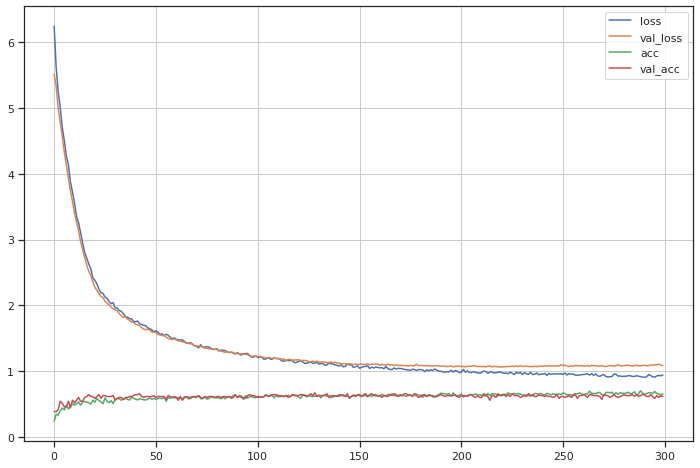

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss', 'acc','val_acc'])
plt.grid()
plt.show()

In [139]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Accuracy = {:.2f}".format(accuracy))

3/3 [==============================] - 0s 3ms/step - loss: 1.0848 - accuracy: 0.6143
Accuracy = 0.61


# **Decision Tree**

In [100]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=16) 
tree_clf.fit(x_train, y_train)


# gini = impurity of each node
# gini == 0 means the node is completely pure and contains data of the same class.
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16, 
                       max_features=None, max_leaf_nodes=None, 
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=1004, splitter='best')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=16, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1004, splitter='best')

In [101]:
pred = tree_clf.predict(x_test)
print("accuracy of decision tree:", accuracy_score(y_test, pred))

accuracy of decision tree: 0.5428571428571428


In [102]:
# accuracy w/o library
c = 0
for i in range (pred.shape[0]):
  if np.all(pred[i, :] == y_test[i, :]):
    c = c+1
print(c/70)    

0.5428571428571428


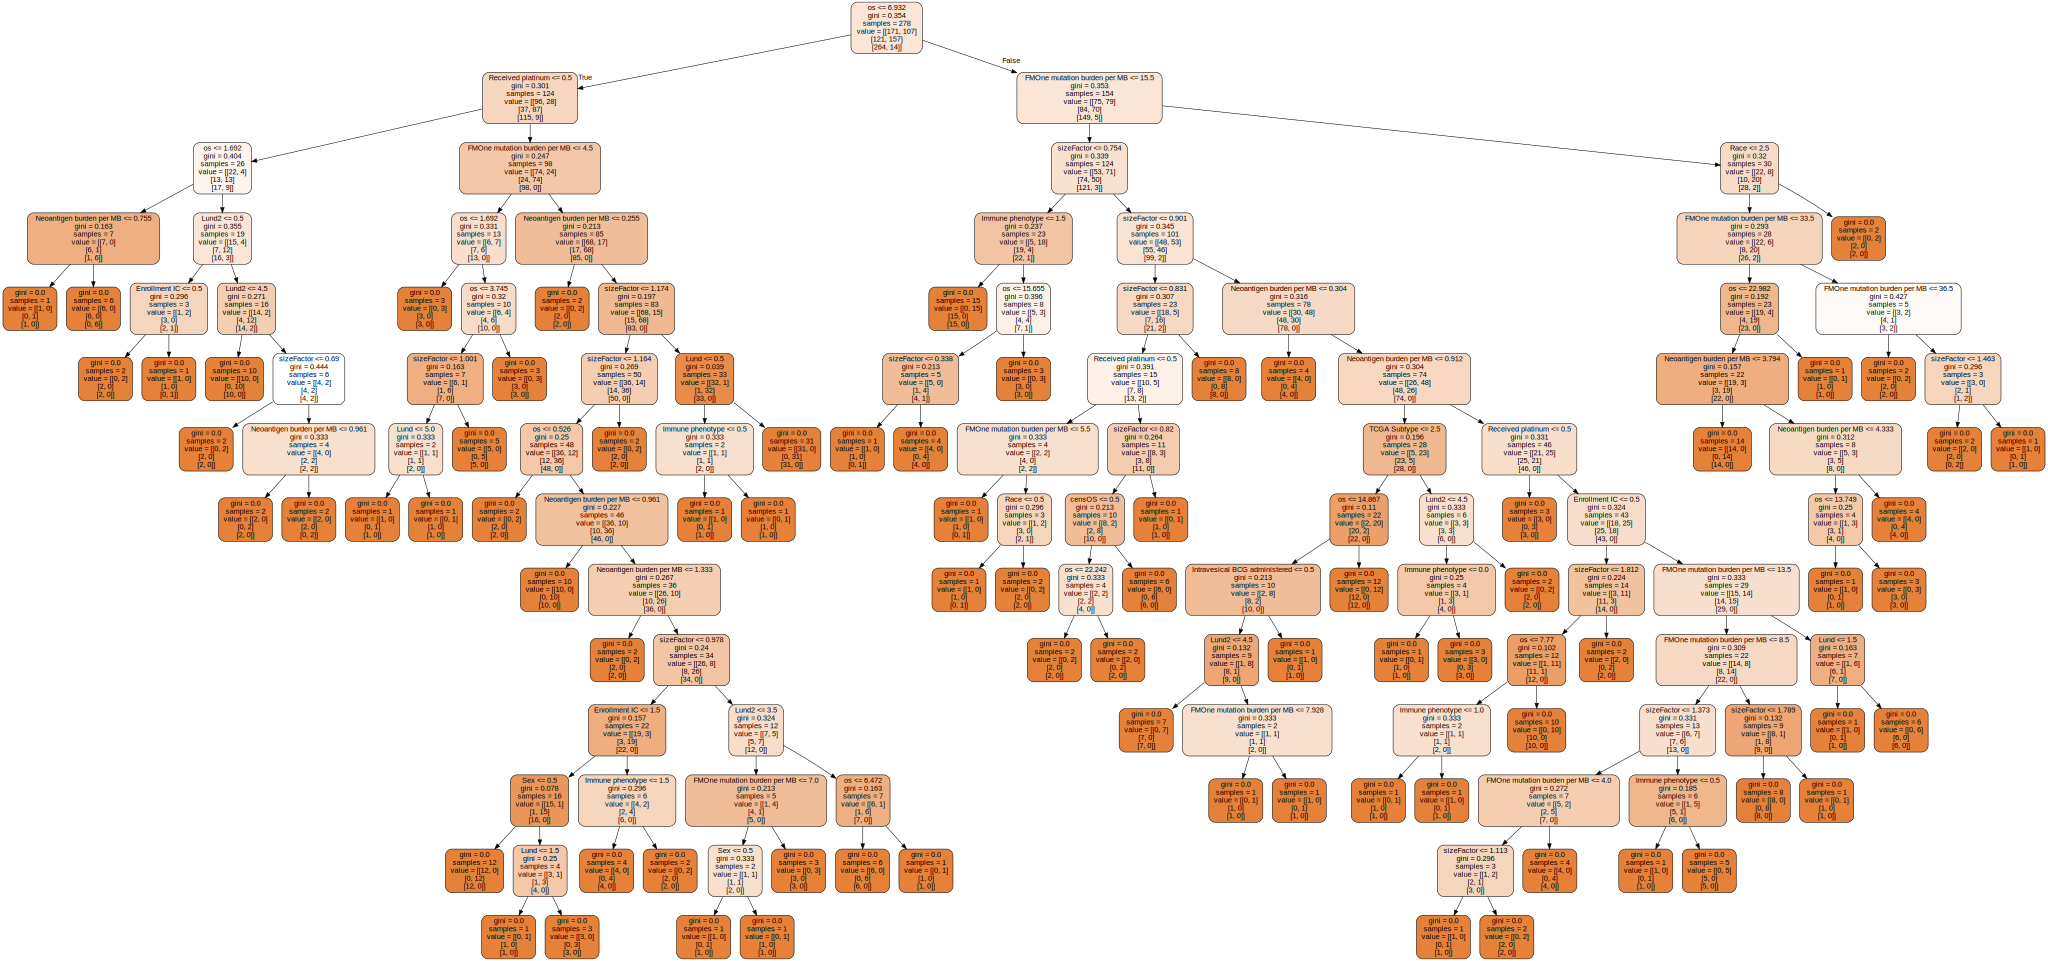

In [103]:
from sklearn.tree import export_graphviz
import graphviz
import os

def image_path(fig_id):
  return os.path.join('./', fig_id)

export_graphviz(
    tree_clf,
    out_file = image_path('tree_' + target_column + '.dot'),
    feature_names = features,
    class_names = target_column,
    rounded = True,
    filled = True
)

with open('tree_' + target_column + '.dot') as f:
  dot_graph = f.read()

dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename = 'tree_'+target_column, directory = './', cleanup = True)
dot